# Disciplines

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

# Design space

In [4]:
from gemseo import configure_logger
configure_logger()

<RootLogger root (INFO)>

In [5]:
from gemseo_oad_training.unit import convert_from
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':100000,'n_pax':20.0,'area':111.58,'ar':8.8912,'fuel_type':'liquid_h2','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)

uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("gi","OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi","OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)
uncertain_space.add_random_variable("aef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef","OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)

In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline

training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=5000)

    INFO - 15:26:56: *** Start Sampling execution ***
    INFO - 15:26:56: Sampling
    INFO - 15:26:56:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:26:56:    MDO formulation: MDF
    INFO - 15:26:56: Running the algorithm OT_MONTE_CARLO:
    INFO - 15:27:43:    100%|██████████| 5000/5000 [00:46<00:00, 107.57 it/sec]
    INFO - 15:27:43: *** End Sampling execution (time: 0:00:46.699064) ***


In [7]:
import matplotlib.pyplot as plt
import pprint

In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)

{'fm': array([1.8809108e-16]),
 'length': array([3.55271368e-15]),
 'mtom': array([7.21824869e-12]),
 'span': array([0.]),
 'tofl': array([2.58061609e-13]),
 'vapp': array([6.64803772e-15]),
 'vz': array([3.28188837e-15])}

In [10]:
rmse.compute_cross_validation_measure(as_dict=True)

{'fm': array([7.02851299e-05]),
 'length': array([3.55271368e-15]),
 'mtom': array([1.9160203]),
 'span': array([0.]),
 'tofl': array([0.07529172]),
 'vapp': array([0.00134012]),
 'vz': array([0.00101939])}

In [11]:
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [12]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.0066107]),
 'cef': array([1.0064927]),
 'fm': array([0.21362866]),
 'gi': array([0.38515354]),
 'length': array([18.08333333]),
 'mtom': array([42822.77288171]),
 'sef': array([1.00664097]),
 'span': array([31.497303]),
 'tofl': array([909.1823907]),
 'vapp': array([55.65974482]),
 'vi': array([0.78669546]),
 'vz': array([10.96901411])}

In [13]:
variance = statistics.compute_variance()
variance

{'aef': array([7.08736647e-05]),
 'cef': array([7.12377957e-05]),
 'fm': array([0.00043429]),
 'gi': array([0.00015496]),
 'length': array([1.26217745e-29]),
 'mtom': array([279274.70838583]),
 'sef': array([7.28066183e-05]),
 'span': array([1.26217745e-29]),
 'tofl': array([403.791842]),
 'vapp': array([0.14362731]),
 'vi': array([0.00012856]),
 'vz': array([0.08614171])}

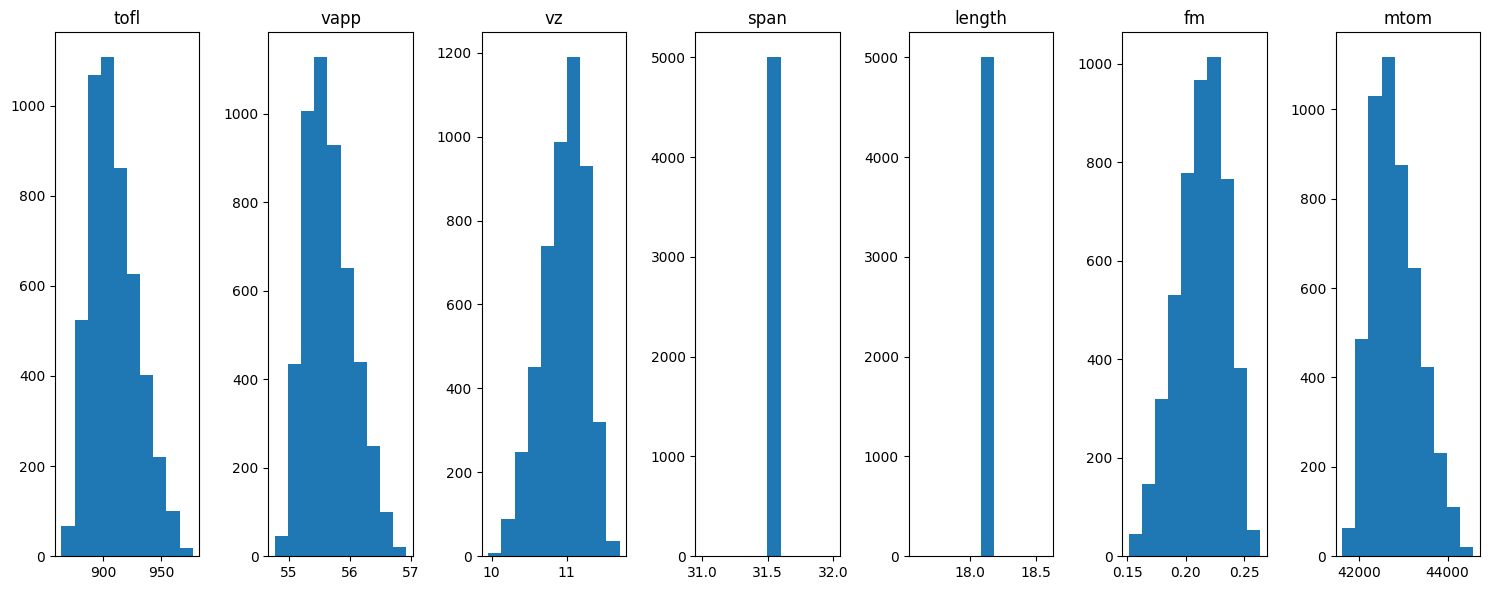

In [14]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [15]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 5000)

 WARNING - 15:27:56: No coupling in MDA, switching chain_linearize to True.
    INFO - 15:27:56: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 15:27:56: SobolAnalysisSamplingPhase
    INFO - 15:27:56:    Disciplines: RBF_Sampling
    INFO - 15:27:56:    MDO formulation: MDF
    INFO - 15:27:56: Running the algorithm OT_SOBOL_INDICES:
    INFO - 15:29:57:    100%|██████████| 4992/4992 [02:00<00:00, 41.26 it/sec]
    INFO - 15:29:57: *** End SobolAnalysisSamplingPhase execution (time: 0:02:01.312999) ***


GROUP        inputs                                           outputs  \
VARIABLE         gi        vi       aef       cef       sef        fm   
COMPONENT         0         0         0         0         0         0   
0          0.394131  0.780767  1.009626  0.991074  1.016893  0.220693   
1          0.366964  0.800344  0.991988  0.992066  1.019799  0.260136   
2          0.394951  0.770859  1.009495  1.024023  1.001250  0.167693   
3          0.375284  0.795927  1.006920  1.011547  1.007358  0.221608   
4          0.375179  0.768572  1.021142  1.006022  0.993472  0.177794   
...             ...       ...       ...       ...       ...       ...   
4987       0.362392  0.784477  1.020361  1.002598  1.005179  0.206657   
4988       0.373582  0.791675  1.002053  1.009646  0.998437  0.220152   
4989       0.398787  0.799326  1.021227  0.999843  1.002129  0.232294   
4990       0.399744  0.763378  1.004281  0.995392  1.014177  0.191541   
4991       0.400118  0.796594  1.007768  1.006853  1.015599  0.227655   

GROUP                                                                 \
VARIABLE      length          mtom       span        tofl       vapp   
COMPONENT          0             0          0           0          0   
0          18.083333  42570.963916  31.497303  899.544485  55.523543   
1          18.083333  43860.570073  31.497303  948.884450  56.469277   
2          18.083333  42250.613691  31.497303  887.519241  55.187227   
3          18.083333  43330.822286  31.497303  928.427756  56.009133   
4          18.083333  42728.362374  31.497303  905.483674  55.571601   
...              ...           ...        ...         ...        ...   
4987       18.083333  43664.070908  31.497303  941.258319  56.254109   
4988       18.083333  43141.851717  31.497303  921.196847  55.887466   
4989       18.083333  42357.992621  31.497303  891.539462  55.323590   
4990       18.083333  42142.119913  31.497303  883.466508  55.207922   
4991       18.083333  42567.301835  31.497303  899.405652  55.473837   

GROUP                 
VARIABLE          vz  
COMPONENT          0  
0          11.085665  
1          10.499368  
2          11.265768  
3          10.687787  
4          10.926970  
...              ...  
4987       10.427081  
4988       10.819909  
4989       11.132553  
4990       11.359558  
4991       11.099228  

[4992 rows x 12 columns]

In [17]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'gi': array([0.83892225]), 'vi': array([0.00549955]), 'aef': array([-0.04333769]), 'cef': array([-0.04053573]), 'sef': array([0.0803084])}], 'vapp': [{'gi': array([0.8645868]), 'vi': array([0.00762776]), 'aef': array([-0.04173718]), 'cef': array([-0.04143053]), 'sef': array([0.08312948])}], 'vz': [{'gi': array([0.7898015]), 'vi': array([0.01631501]), 'aef': array([0.00481927]), 'cef': array([-0.02493368]), 'sef': array([0.08811542])}], 'fm': [{'gi': array([-0.00918241]), 'vi': array([0.76450463]), 'aef': array([0.05814467]), 'cef': array([0.25251556]), 'sef': array([-0.00905753])}], 'mtom': [{'gi': array([0.83826489]), 'vi': array([0.00623888]), 'aef': array([-0.04277014]), 'cef': array([-0.04005528]), 'sef': array([0.08178758])}]}, second={'tofl': [{'gi': {'gi': array([[0.]]), 'vi': array([[0.04737367]]), 'aef': array([[0.04539896]]), 'cef': array([[0.03772667]]), 'sef': array([[0.02565147]])}, 'vi': {'gi': array([[0.04737367]]), 'vi':

In [18]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([0.05814467]),
         'cef': array([0.25251556]),
         'gi': array([-0.00918241]),
         'sef': array([-0.00905753]),
         'vi': array([0.76450463])}],
 'mtom': [{'aef': array([-0.04277014]),
           'cef': array([-0.04005528]),
           'gi': array([0.83826489]),
           'sef': array([0.08178758]),
           'vi': array([0.00623888])}],
 'tofl': [{'aef': array([-0.04333769]),
           'cef': array([-0.04053573]),
           'gi': array([0.83892225]),
           'sef': array([0.0803084]),
           'vi': array([0.00549955])}],
 'vapp': [{'aef': array([-0.04173718]),
           'cef': array([-0.04143053]),
           'gi': array([0.8645868]),
           'sef': array([0.08312948]),
           'vi': array([0.00762776])}],
 'vz': [{'aef': array([0.00481927]),
         'cef': array([-0.02493368]),
         'gi': array([0.7898015]),
         'sef': array([0.08811542]),
         'vi': array([0.01631501])}]}
{'fm': [{'aef': array([0.06735641]),
  

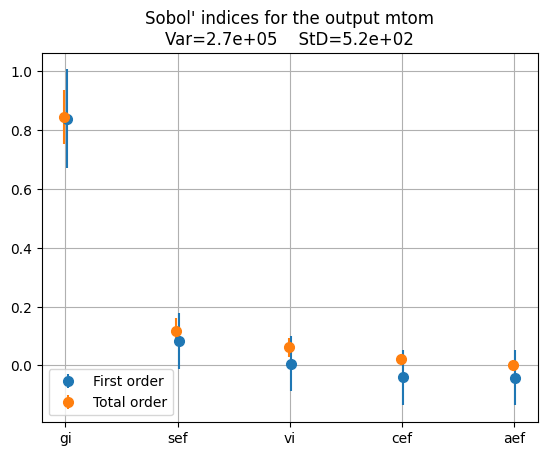

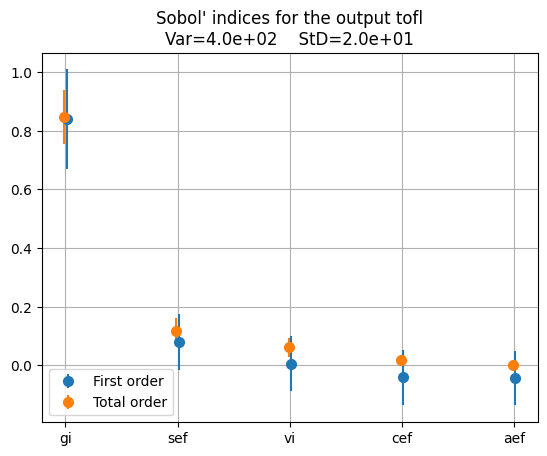

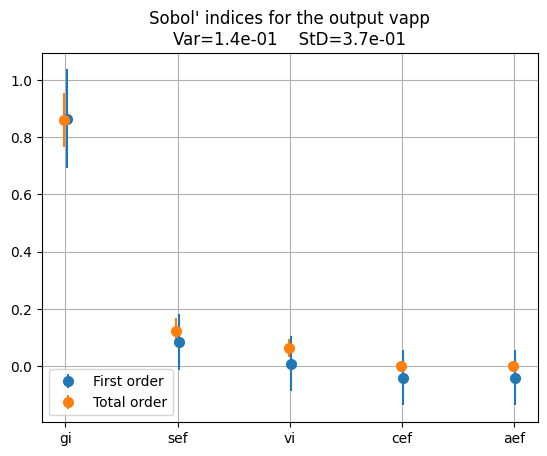

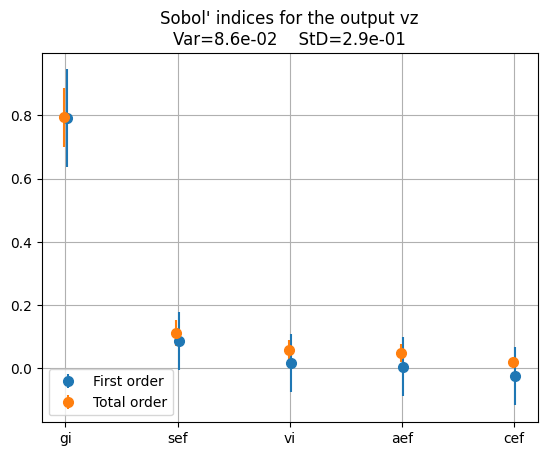

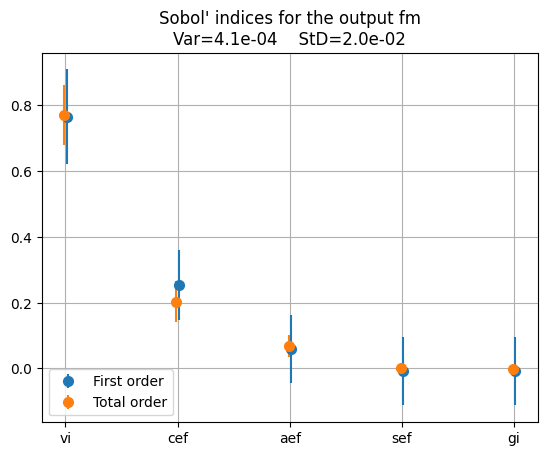

In [19]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))